# Segment

Segment mouse pixels from background pixels

In [2]:
PARAMS = {
    'session_name':'mice2_v2',
    'background_session_name':'background',
    'working_directory':'open_air_v1',
    'n_background_frames':100,
    'background_update_rate': 0.2,
    'min_depth_difference': 5,
    'max_depth_difference': 500,
    'min_color_component_size': 500,
    'max_color_component_brightness': 100,
    'max_color_component_aspect_ratio': 10,
    'max_color_component_island_size': 500,
    'skip_first_frames':100
}

In [12]:
import shutil, json, os, sys, time, pickle, h5py, cv2, numpy as np, matplotlib.pyplot as plt, h5py
from MoseqMulti_segment import *
%matplotlib inline

### Get initial background images

In [13]:
data = h5py.File(PARAMS['working_directory']+'/data/'+PARAMS['background_session_name']+'.hdf5','r')
depth_backgrounds = get_depth_background(data, PARAMS['n_background_frames'])
color_backgrounds = get_color_background(data, PARAMS['n_background_frames'])
data.close()

Calculating background depth for camera 739112061202
Calculating background depth for camera 816312062005
Calculating background depth for camera 816312061973
Calculating background depth for camera 739112060301
Calculating background depth for camera 816312062021
Calculating background color for camera 739112061202
Calculating background color for camera 816312062005
Calculating background color for camera 816312061973
Calculating background color for camera 739112060301
Calculating background color for camera 816312062021


### For each camera, do adaptive color and depth. Use color for adaptive masking

In [14]:
data = h5py.File(PARAMS['working_directory']+'/data/'+PARAMS['session_name']+'.hdf5','r+')
metadata = json.load(open(PARAMS['working_directory']+'/data/'+PARAMS['session_name']+'_metadata.json'))

In [15]:
for sn in metadata['serial_numbers']:
    if not sn+'/depth_segmentation/' in data:
        data[sn].create_dataset('color_segmentation', data[sn]['depth'].shape, dtype='bool')
        data[sn].create_dataset('depth_segmentation', data[sn]['depth'].shape, dtype='bool')

In [16]:
def color_seg(x,bg):
    try:
        y = np.array(np.abs((x/x.sum(2)[:,:,None] - bg/bg.sum(2)[:,:,None])).sum(2),dtype=float) * bg.sum(2)
        th =  threshold_otsu(y)
        th = np.max([th, 22])
        t1 = y > th

    except: t1 = np.zeros(x.shape[:2])
    y = np.array(np.abs((x - bg)).sum(2),dtype=float)
    th = threshold_otsu(y)
    t2 = y > th
    return np.any([t1,t2],axis=0)


In [21]:
for sn in metadata['serial_numbers'][2:3]:
    print('Segmenting camera',sn)
    color_bg = color_backgrounds[sn]
    depth_bg = depth_backgrounds[sn]
    for current_frame in range(PARAMS['skip_first_frames'],data[sn]['color_segmentation'].shape[0]):
        if current_frame % 10==0: print('...on frame',current_frame,'out of',data[sn]['color_segmentation'].shape[0])
        Xcolor = data[sn]['color'][current_frame,:,:,:]
        Xdepth = data[sn]['depth'][current_frame,:,:]
        color_mask = clean_color_seg(color_seg(Xcolor,color_bg), Xcolor, PARAMS)
        depth_mask = depth_seg(Xdepth,depth_bg, PARAMS)
        final_mask = np.all([color_mask, depth_mask], axis=0)
        data[sn]['depth_segmentation'][current_frame,:,:] = final_mask
        data[sn]['color_segmentation'][current_frame,:,:] = color_mask>0
        color_bg, depth_bg = update_background(color_bg, depth_bg, Xcolor, Xdepth, color_mask, PARAMS['background_update_rate'])

data.close()

Segmenting camera 816312061973
...on frame 100 out of 4314
...on frame 110 out of 4314
...on frame 120 out of 4314
...on frame 130 out of 4314
...on frame 140 out of 4314
...on frame 150 out of 4314
...on frame 160 out of 4314
...on frame 170 out of 4314
...on frame 180 out of 4314
...on frame 190 out of 4314
...on frame 200 out of 4314
...on frame 210 out of 4314
...on frame 220 out of 4314
...on frame 230 out of 4314
...on frame 240 out of 4314
...on frame 250 out of 4314
...on frame 260 out of 4314
...on frame 270 out of 4314
...on frame 280 out of 4314
...on frame 290 out of 4314
...on frame 300 out of 4314
...on frame 310 out of 4314
...on frame 320 out of 4314
...on frame 330 out of 4314
...on frame 340 out of 4314
...on frame 350 out of 4314
...on frame 360 out of 4314
...on frame 370 out of 4314
...on frame 380 out of 4314
...on frame 390 out of 4314
...on frame 400 out of 4314
...on frame 410 out of 4314
...on frame 420 out of 4314
...on frame 430 out of 4314
...on frame 440 o

In [8]:
sn = metadata['serial_numbers'][2]

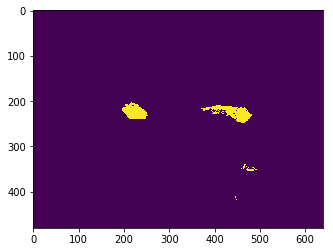

In [20]:
plt.imshow(data[sn]['depth_segmentation'][100,:,:])